In [95]:
from sklearn.cluster import KMeans
import numpy as np
import csv
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt
import pandas as pd

In [96]:
maxAcc = 0.0
maxIter = 0
C_Lambda = 0.03
TrainingPercent = 80
ValidationPercent = 10
TestPercent = 10
M = 10
PHI = []
IsSynthetic = False

In [97]:
SAME_PAIR_FILE=['HumanObserved-Dataset/HumanObserved-Dataset/HumanObserved-Features-Data/same_pairs.csv','GSC-Dataset(1)/GSC-Dataset/GSC-Features-Data/same_pairs.csv']
DIFF_PAIR_FILE=['HumanObserved-Dataset/HumanObserved-Dataset/HumanObserved-Features-Data/diffn_pairs.csv','GSC-Dataset(1)/GSC-Dataset/GSC-Features-Data/diffn_pairs.csv']
FEATURE_DATA_SET_FILE=['HumanObserved-Dataset/HumanObserved-Dataset/HumanObserved-Features-Data/HumanObserved-Features-Data.csv','GSC-Dataset(1)/GSC-Dataset/GSC-Features-Data/GSC-Features.csv']
COL_NUM=[9,512]
SAMPLE_SIZE=[761,5000]
DATASET_TYPE={
    "HUMAN":1,
    "GSC":2
}
OPERATION_TYPE={
    "CONCAT":1,
    "SUBTRACT":2
}

In [98]:
def GenerateColMapper(lim):
    col={}
    col['img_id']='img_id'
    for i in range(1,lim+1):
        col['f'+str(i)]='f'+str(i+lim)
    return col

def MergeDatasets(df1,df2,col_val):
    res_df = pd.merge(df1,df2,left_on='img_id_A', right_on='img_id', how='inner')
    res_df.drop(['img_id'],axis=1, inplace= True)
    col = GenerateColMapper(col_val)
    df2=df2.rename(columns=col)
    res_df = pd.merge(res_df,df2,left_on='img_id_B',right_on='img_id', how='inner')
    res_df.drop(['img_id'],axis=1, inplace= True)
    return res_df

def SubtractDatasets(pairs_df,feature_df):
    target_dff=pairs_df['target']
    print("target_df.shape",target_dff.shape)
    df1 = pd.merge(pairs_df,feature_df,left_on='img_id_A', right_on='img_id', how='inner')
    df1.drop(['img_id','img_id_A','img_id_B','target'],axis=1, inplace= True)
    df2 = pd.merge(pairs_df,feature_df,left_on='img_id_B',right_on='img_id', how='inner')
    df2.drop(['img_id','img_id_A','img_id_B','target'],axis=1, inplace= True)
    res_df = df1-df2
    res2_df=pd.concat([res_df,target_dff],axis=1)
    return res2_df

In [99]:
def PrepareDataSet(dataset_type,op_type):
    same_pairs_df = pd.read_csv(SAME_PAIR_FILE[dataset_type-1]).sample(SAMPLE_SIZE[dataset_type-1], replace=False).reset_index(drop=True)
    diff_pairs_df = pd.read_csv(DIFF_PAIR_FILE[dataset_type-1]).sample(SAMPLE_SIZE[dataset_type-1], replace=False).reset_index(drop=True)
    feature_data_df = pd.read_csv(FEATURE_DATA_SET_FILE[dataset_type-1])
    if(op_type==1): 
        final_df = MergeDatasets(same_pairs_df,feature_data_df,COL_NUM[dataset_type-1])
        final_df=final_df.append(MergeDatasets(diff_pairs_df,feature_data_df,COL_NUM[dataset_type-1]))
        target_df=final_df['target']
        final_df.drop(['img_id_A','img_id_B','target'],axis=1, inplace= True)
        final_df=pd.concat([final_df,target_df],axis=1)
    elif(op_type==2):
        dff1=SubtractDatasets(same_pairs_df,feature_data_df)
        dff2=SubtractDatasets(diff_pairs_df,feature_data_df)
        final_df = dff1.append(dff2)
    final_df = final_df.sample(frac=1).reset_index(drop=True)
    return final_df

res_data_df = PrepareDataSet(DATASET_TYPE['GSC'],OPERATION_TYPE['SUBTRACT'])

target_df.shape (5000,)
target_df.shape (5000,)


In [100]:
# Returns first TrainingPercent% data of the target output list which is used to train the model
def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    #print(str(TrainingPercent) + "% Training Target Generated..")
    return t

# Returns first TrainingPercent% data of the input vectors list which is used to to train the model
def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):
    T_len = int(math.ceil(len(rawData[0])*0.01*TrainingPercent))
    d2 = rawData[:,0:T_len]
    #print(str(TrainingPercent) + "% Training Data Generated..")
    return d2

#Returns first ValPercent% data of the target output list which is used as validation data
def GenerateValData(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[:,TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Data Generated..")  
    return dataMatrix

#Returns first ValPercent% data of the target output list which is used as validation data
def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Target Data Generated..")
    return t

# Returns the BigSigma (or covariance) Matrix used for evaluating phi matrix (basis functions)
def GenerateBigSigma(Data, MuMatrix,TrainingPercent,IsSynthetic):
    BigSigma    = np.zeros((len(Data),len(Data)))
    DataT       = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))        
    varVect     = []
    for i in range(0,len(DataT[0])):
        vct = []
        for j in range(0,int(TrainingLen)):
            vct.append(Data[i][j])    
        varVect.append(np.var(vct))
    
    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j]
    if IsSynthetic == True:
        BigSigma = np.dot(3,BigSigma)
    else:
        BigSigma = np.dot(200,BigSigma)
    print(DataT.shape)
    ##print ("BigSigma Generated..")
    return BigSigma

# Returns the exponent of the Euler number for calculating the basis  function matrix
def GetScalar(DataRow,MuRow, BigSigInv):  
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    return L

# Returns the Rth row and Cth column value of the PHI Matrix
def GetRadialBasisOut(DataRow,MuRow, BigSigInv):    
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x

# Returns the complete Phi Matrix (Numpy Array)
def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.pinv(BigSigma) # Computes inverse of the BigSigma matrix
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI

# Computes and returns weights matrix for Closed-form solution from PHI(basis function matrix), T(Target output variable) and Lambda (Regularization parameter)
def GetWeightsClosedForm(PHI, T, Lambda):
    print("PHI shape",PHI.shape)
    print("T shape",T.shape)
    #print(Lambda.shape)
    Lambda_I = np.identity(len(PHI[0]))
    for i in range(0,len(PHI[0])):
        Lambda_I[i][i] = Lambda
    PHI_T       = np.transpose(PHI)
    PHI_SQR     = np.dot(PHI_T,PHI)
    PHI_SQR_LI  = np.add(Lambda_I,PHI_SQR)
    PHI_SQR_INV = np.linalg.inv(PHI_SQR_LI)
    INTER       = np.dot(PHI_SQR_INV, PHI_T)
    W           = np.dot(INTER, T)
    ##print ("Training Weights Generated..")
    return W

# Computes and returns the predicted variable from Design Matrix PHI and Weight matrix W
def GetValTest(VAL_PHI,W):
    Y = np.dot(W,np.transpose(VAL_PHI))
    ##print ("Test Out Generated..")
    return Y

# Computes and returns Root Mean square error from the predicted output matrix and the actual output matrix
def GetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

## Fetch and Prepare Dataset

In [101]:
RawTarget = res_data_df['target'].values
raw_data_df=res_data_df
raw_data_df.drop(['target'],axis=1, inplace= True)
RawData   = np.transpose(raw_data_df.values)
print(res_data_df.values)
print(RawData)
print(RawTarget.shape)

[[ 0  1  1 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  1 ...  0  0  0]
 ...
 [ 1 -1 -1 ...  0  0  0]
 [-1  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
[[ 0  0  0 ...  1 -1  0]
 [ 1  0  0 ... -1  0  0]
 [ 1  0  1 ... -1  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
(10000,)


## Prepare Training Data

In [102]:
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)

(8000,)
(512, 8000)


## Prepare Validation Data

In [103]:
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)

(999,)
(512, 999)


## Prepare Test Data

In [104]:
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(ValDataAct.shape)
print(ValData.shape)

(999,)
(512, 999)


## Closed Form Solution [Finding Weights using Moore- Penrose pseudo- Inverse Matrix]

In [105]:
ErmsArr = []
AccuracyArr = []

# Here we are using k means clustering algorithm to calculate the mean or centroid of M clusters
kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData))
Mu = kmeans.cluster_centers_

BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)

(10000, 512)
PHI shape (8000, 10)
T shape (8000,)


## Finding Erms on training, validation and test set 

In [106]:
TR_TEST_OUT  = GetValTest(TRAINING_PHI,W)
VAL_TEST_OUT = GetValTest(VAL_PHI,W)
TEST_OUT     = GetValTest(TEST_PHI,W)

TrainingAccuracy   = str(GetErms(TR_TEST_OUT,TrainingTarget))
ValidationAccuracy = str(GetErms(VAL_TEST_OUT,ValDataAct))
TestAccuracy       = str(GetErms(TEST_OUT,TestDataAct))

In [107]:
##print ('UBITname      = gagansun')
##print ('Person Number = 50278729')
##print ('----------------------------------------------------')
##print ("------------------LeToR Data------------------------")
##print ('----------------------------------------------------')
##print ("-------Closed Form with Radial Basis Function-------")
##print ('----------------------------------------------------')
##print ("M = ",M," \nLambda = ",C_Lambda)
##print ("E_rms Training   = " + str(float(TrainingAccuracy.split(',')[1])))
##print ("E_rms Training   = " + str(TrainingAccuracy.split(',')))
##print ("E_rms Validation = " + str(float(ValidationAccuracy.split(',')[1])))
##print ("E_rms Validation = " + str(ValidationAccuracy.split(',')))
##print ("E_rms Testing    = " + str(float(TestAccuracy.split(',')[1])))
##print ("E_rms Testing    = " + str(TestAccuracy.split(',')))

## Gradient Descent solution for Linear Regression

In [108]:
print ('----------------------------------------------------')
print ('--------------Please Wait for 2 mins!----------------')
print ('----------------------------------------------------')

----------------------------------------------------
--------------Please Wait for 2 mins!----------------
----------------------------------------------------


In [109]:
def GradientDescent(Lambda,lRate):
    W_Now        = np.dot(220, W)
    La           = Lambda
    learningRate = lRate
    L_Erms_Val   = []
    L_Erms_TR    = []
    L_Erms_Test  = []
    W_Mat        = []
    print("Stochastic Gradient Descent started")
    for i in range(min(TrainingTarget.shape[0],2500)):
        #print ('---------Iteration: ' + str(i) + '--------------')
        Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
        La_Delta_E_W  = np.dot(La,W_Now)
        Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
        Delta_W       = -np.dot(learningRate,Delta_E) 
        W_T_Next      = W_Now + Delta_W # Here, New weights are calculated in each iteration
        W_Now         = W_T_Next

        #-----------------TrainingData Accuracy---------------------#
        TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next)
        #print(TR_TEST_OUT)
        Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
        L_Erms_TR.append(Erms_TR.split(','))

        #-----------------ValidationData Accuracy---------------------#
        VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 

        Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
        L_Erms_Val.append(Erms_Val.split(','))

        #-----------------TestingData Accuracy---------------------#
        TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 

        Erms_Test = GetErms(TEST_OUT,TestDataAct)
        L_Erms_Test.append(Erms_Test.split(','))
    return L_Erms_TR,L_Erms_Val,L_Erms_Test

In [120]:

L_Erms_TR,L_Erms_Val,L_Erms_Test=GradientDescent(Lambda=2,lRate=0.0009)

Stochastic Gradient Descent started


['50.65', '0.5714425736134602']
['48.448448448448445', '0.57947036577364']
['48.448448448448445', '0.57947036577364']


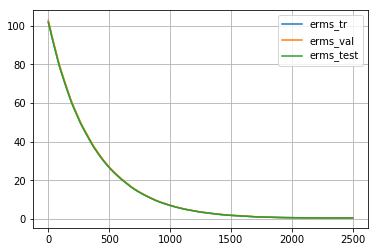

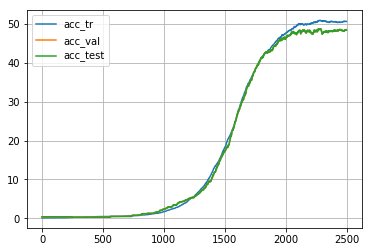

In [121]:


Erms_TR=[]
Erms_Val=[]
Acc_TR=[]
Erms_Test=[]

Acc_Val=[]
Acc_Test=[]
for i in range(len(L_Erms_TR)):
    Erms_TR.append(float(L_Erms_TR[i][1]))
    Acc_TR.append(float(L_Erms_TR[i][0]))
for i in range(len(L_Erms_Val)):
    Erms_Val.append(float(L_Erms_Val[i][1]))
    Acc_Val.append(float(L_Erms_Val[i][0]))
for i in range(len(L_Erms_Test)):
    Erms_Test.append(float(L_Erms_Test[i][1]))
    Acc_Test.append(float(L_Erms_Val[i][0]))

print(L_Erms_TR[-1])
print(L_Erms_Val[-1])
print(L_Erms_Val[-1])
df_Erms=pd.DataFrame()
df_Erms['erms_tr']=Erms_TR
df_Erms['erms_val']=Erms_Val
df_Erms['erms_test']=Erms_Test
df_Erms.plot(grid=True)

df_Acc=pd.DataFrame()
df_Acc['acc_tr']=Acc_TR
df_Acc['acc_val']=Acc_Val
df_Acc['acc_test']=Acc_Test
df_Acc.plot(grid=True)
#print(C_Lambda)


# Logistic Regression

In [140]:
def EvalSigmoid(Xi,W_log):
    return (1.0/(1 + np.exp(-(np.dot(Xi,W_log)))))

def TuneWeights():
    eta=0.06
    X=raw_data_df.values
    #print(X.shape)
    NO_OF_FEATURES=X.shape[1]
    W_log = np.zeros((NO_OF_FEATURES,1))
    A=np.around(EvalSigmoid(X,W_log))
    #print(A)
    #np.zeros((len(X),1))
    for j in range(1):
        for i in range(0,len(A)):
            #print(W_log)
            temp=(EvalSigmoid(X[i],W_log))
            #print("temp=",temp)
            W_log=np.subtract(W_log,(eta*np.reshape((X[i]*(temp[0]-RawTarget[i])),(NO_OF_FEATURES,1))))
            #print(temp)
    return W_log

In [141]:
W_log=TuneWeights()
#print(W_log.shape)
#print(W_log)
A_Train= EvalSigmoid((raw_data_df.values),W_log)
A_Val=EvalSigmoid(np.transpose(ValData),W_log)
A_Test=EvalSigmoid(np.transpose(TestData),W_log)
Erms_Tr=GetErms(A_Train,np.transpose(RawTarget))
Erms_Val=GetErms(A_Val,np.transpose(ValDataAct))
Erms_Test=GetErms(A_Test,np.transpose(TestDataAct))
print(Erms_Tr)
print(Erms_Val)
print(Erms_Test)

54.16,0.6156664943339379
54.95495495495496,0.6064988533797337
67.36736736736736,0.505193161516175
